# Stitching Tutorial

The Workflow of the Stitching Pipeline can be seen in the following. Note that the image comes from the [OpenCV Documentation](https://docs.opencv.org/3.4/d1/d46/group__stitching.html).

With the following block, we allow displaying resulting images within the notebook:

In [5]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np

def plot_image(img, figsize_in_inches=(5,5)):
    fig, ax = plt.subplots(figsize=figsize_in_inches)
    ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()
    
def plot_images(imgs, figsize_in_inches=(5,5)):
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize_in_inches)
    for col, img in enumerate(imgs):
        axs[col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

With the following block, we load the correct img paths to the used image sets:

In [6]:
from pathlib import Path
def get_image_paths(img_set):
    return [str(path.relative_to('.')) for path in Path('../../data/sequential_training').rglob(f'{img_set}*')]

sequential_imgs = get_image_paths('')
sequential_imgs = sorted(sequential_imgs)[32:40]

In [7]:
len(sequential_imgs)

8

## Resize Images

The first step is to resize the images to medium (and later to low) resolution. The class which can be used is the `ImageHandler` class. If the images should not be stitched on full resolution, this can be achieved by setting the `final_megapix` parameter to a number above 0. 

`ImageHandler(medium_megapix=0.6, low_megapix=0.1, final_megapix=-1)`

In [8]:
from stitching.image_handler import ImageHandler

img_handler = ImageHandler()
img_handler.set_img_names(sequential_imgs)

medium_imgs = list(img_handler.resize_to_medium_resolution())
low_imgs = list(img_handler.resize_to_low_resolution(medium_imgs))
final_imgs = list(img_handler.resize_to_final_resolution())

**NOTE:** Everytime `list()` is called in this notebook means that the function returns a generator (generators improve the overall stitching performance). To get all elements at once we use `list(generator_object)`  

In [9]:
# plot_images(low_imgs, (20,20))

In [10]:
original_size = img_handler.img_sizes[0]
medium_size = img_handler.get_image_size(medium_imgs[0])
low_size = img_handler.get_image_size(low_imgs[0])
final_size = img_handler.get_image_size(final_imgs[0])

print(f"Original Size: {original_size}  -> {'{:,}'.format(np.prod(original_size))} px ~ 1 MP")
print(f"Medium Size:   {medium_size}  -> {'{:,}'.format(np.prod(medium_size))} px ~ 0.6 MP")
print(f"Low Size:      {low_size}   -> {'{:,}'.format(np.prod(low_size))} px ~ 0.1 MP")
print(f"Final Size:    {final_size}  -> {'{:,}'.format(np.prod(final_size))} px ~ 1 MP")

Original Size: (224, 224)  -> 50,176 px ~ 1 MP
Medium Size:   (224, 224)  -> 50,176 px ~ 0.6 MP
Low Size:      (224, 224)   -> 50,176 px ~ 0.1 MP
Final Size:    (224, 224)  -> 50,176 px ~ 1 MP


## Find Features

On the medium images, we now want to find features that can describe conspicuous elements within the images which might be found in other images as well. The class which can be used is the `FeatureDetector` class.

`FeatureDetector(detector='orb', nfeatures=500)`

In [11]:
from stitching.feature_detector import FeatureDetector

finder = FeatureDetector()
features = [finder.detect_features(img) for img in medium_imgs]
keypoints_center_img = finder.draw_keypoints(medium_imgs[1], features[1])

## Match Features

Now we can match the features of the pairwise images. The class which can be used is the FeatureMatcher class.

`FeatureMatcher(matcher_type='homography', range_width=-1)`

In [13]:
from stitching.feature_matcher import FeatureMatcher

matcher = FeatureMatcher()
matches = matcher.match_features(features)

We can look at the confidences, which are calculated by:

`confidence = number of inliers / (8 + 0.3 * number of matches)` (Lines 435-7 of [this file](https://github.com/opencv/opencv/blob/68d15fc62edad980f1ffa15ee478438335f39cc3/modules/stitching/src/matchers.cpp))

The inliers are calculated using the random sample consensus (RANSAC) method, e.g. in [this file](https://github.com/opencv/opencv/blob/68d15fc62edad980f1ffa15ee478438335f39cc3/modules/stitching/src/matchers.cpp) in Line 425. We can plot the inliers which is shown later.

In [14]:
matcher.get_confidence_matrix(matches)

array([[0.        , 0.36363636, 1.57024793, 2.24852071, 0.37313433,
        0.74468085, 0.4       , 0.5       ],
       [0.36363636, 0.        , 1.81102362, 0.37313433, 0.48      ,
        0.40983607, 0.45454545, 0.37383178],
       [1.57024793, 1.81102362, 0.        , 0.75949367, 0.43103448,
        1.26373626, 0.43103448, 0.36363636],
       [2.24852071, 0.37313433, 0.75949367, 0.        , 1.65384615,
        1.85810811, 1.19318182, 0.40983607],
       [0.37313433, 0.48      , 0.43103448, 1.65384615, 0.        ,
        1.05882353, 2.18309859, 1.67464115],
       [0.74468085, 0.40983607, 1.26373626, 1.85810811, 1.05882353,
        0.        , 2.26829268, 0.3539823 ],
       [0.4       , 0.45454545, 0.43103448, 1.19318182, 2.18309859,
        2.26829268, 0.        , 0.6870229 ],
       [0.5       , 0.37383178, 0.36363636, 0.40983607, 1.67464115,
        0.3539823 , 0.6870229 , 0.        ]])

It can be seen that:

- image 1 has a high matching confidence with image 2 and low confidences with image 3 and 4
- image 2 has a high matching confidence with image 1 and image 3 and low confidences with image 4
- image 3 has a high matching confidence with image 2 and low confidences with image 1 and 4
- image 4 has low matching confidences with image 1, 2 and 3

With a `confidence_threshold`, which is introduced in detail in the next step, we can plot the relevant matches with the inliers:

In [15]:
all_relevant_matches = matcher.draw_matches_matrix(medium_imgs, features, matches, conf_thresh=1, 
                                                   inliers=True, matchColor=(0, 255, 0))

# for idx1, idx2, img in all_relevant_matches:
#     print(f"Matches Image {idx1+1} to Image {idx2+1}")
#     plot_image(img, (20,10))

## Subset

Above we saw that the noise image has no connection to the other images which are part of the panorama. We now want to create a subset with only the relevant images. The class which can be used is the `Subsetter` class. We can specify the `confidence_threshold` from when a match is regarded as good match. We saw that in our case `1` is sufficient. For the parameter `matches_graph_dot_file` a file name can be passed, in which a matches graph in dot notation is saved. 

`Subsetter(confidence_threshold=1, matches_graph_dot_file=None)`

In [16]:
from stitching.subsetter import Subsetter

subsetter = Subsetter()
dot_notation = subsetter.get_matches_graph(img_handler.img_names, matches)
print(dot_notation)

graph matches_graph{
"000000032.jpg" -- "000000034.jpg"[label="Nm=54, Ni=38, C=1.57025"];
"000000032.jpg" -- "000000035.jpg"[label="Nm=86, Ni=76, C=2.24852"];
"000000033.jpg" -- "000000034.jpg"[label="Nm=58, Ni=46, C=1.81102"];
"000000034.jpg" -- "000000037.jpg"[label="Nm=34, Ni=23, C=1.26374"];
"000000035.jpg" -- "000000036.jpg"[label="Nm=60, Ni=43, C=1.65385"];
"000000035.jpg" -- "000000038.jpg"[label="Nm=32, Ni=21, C=1.19318"];
"000000036.jpg" -- "000000039.jpg"[label="Nm=43, Ni=35, C=1.67464"];
}


The matches graph visualizes what we've saw in the confidence matrix: image 1 conneced to image 2 conneced to image 3. Image 4 is not part of the panorama (note that the confidences can vary since this is a static image). 

![match_graph](https://github.com/lukasalexanderweber/opencv_stitching_tutorial/blob/master/docs/static_files/match_graph.png?raw=true)

[GraphvizOnline](https://dreampuf.github.io/GraphvizOnline) is used to plot the graph

We now want to subset all variables we've created till here, incl. the attributes `img_names` and `img_sizes` of the `ImageHandler`

In [17]:
indices = subsetter.get_indices_to_keep(features, matches)

medium_imgs = subsetter.subset_list(medium_imgs, indices)
low_imgs = subsetter.subset_list(low_imgs, indices)
final_imgs = subsetter.subset_list(final_imgs, indices)
features = subsetter.subset_list(features, indices)
matches = subsetter.subset_matches(matches, indices)

img_names = subsetter.subset_list(img_handler.img_names, indices)
img_sizes = subsetter.subset_list(img_handler.img_sizes, indices)

img_handler.img_names, img_handler.img_sizes = img_names, img_sizes

## Camera Estimation, Adjustion and Correction

With the features and matches we now want to calibrate cameras which can be used to warp the images so they can be composed correctly. The classes which can be used are `CameraEstimator`, `CameraAdjuster` and `WaveCorrector`:

```
CameraEstimator(estimator='homography')
CameraAdjuster(adjuster='ray', refinement_mask='xxxxx')
WaveCorrector(wave_correct_kind='horiz')
```

In [18]:
from stitching.camera_estimator import CameraEstimator
from stitching.camera_adjuster import CameraAdjuster
from stitching.camera_wave_corrector import WaveCorrector

camera_estimator = CameraEstimator()
camera_adjuster = CameraAdjuster()
wave_corrector = WaveCorrector()

cameras = camera_estimator.estimate(features, matches)
cameras = camera_adjuster.adjust(features, matches, cameras)
cameras = wave_corrector.correct(cameras)

## Warp Images

With the obtained cameras we now want to warp the images itself into the final plane. The class which can be used is the `Warper` class:

`Warper(warper_type='spherical', scale=1)`

In [19]:
from stitching.warper import Warper

warper = Warper()

At first, we set the the medium focal length of the cameras as scale:

In [20]:
warper.set_scale(cameras)

Warp low resolution images

In [21]:
low_sizes = img_handler.get_low_img_sizes()
camera_aspect = img_handler.get_medium_to_low_ratio()      # since cameras were obtained on medium imgs

warped_low_imgs = list(warper.warp_images(low_imgs, cameras, camera_aspect))
warped_low_masks = list(warper.create_and_warp_masks(low_sizes, cameras, camera_aspect))
low_corners, low_sizes = warper.warp_rois(low_sizes, cameras, camera_aspect)

Warp final resolution images

In [22]:
final_sizes = img_handler.get_final_img_sizes()
camera_aspect = img_handler.get_medium_to_final_ratio()    # since cameras were obtained on medium imgs

warped_final_imgs = list(warper.warp_images(final_imgs, cameras, camera_aspect))
warped_final_masks = list(warper.create_and_warp_masks(final_sizes, cameras, camera_aspect))
final_corners, final_sizes = warper.warp_rois(final_sizes, cameras, camera_aspect)

## Excursion: Timelapser

The Timelapser functionality is a nice way to grasp how the images are warped into a final plane. The class which can be used is the `Timelapser` class:

`Timelapser(timelapse='no')`

(112, 226)


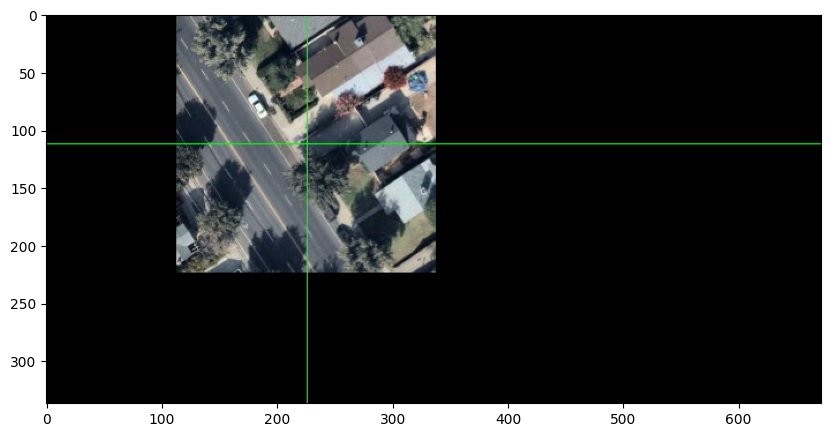

(224, 112)


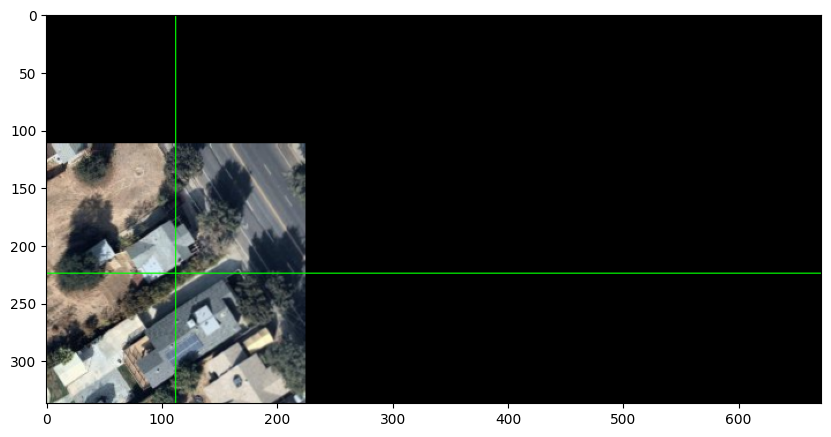

(224, 226)


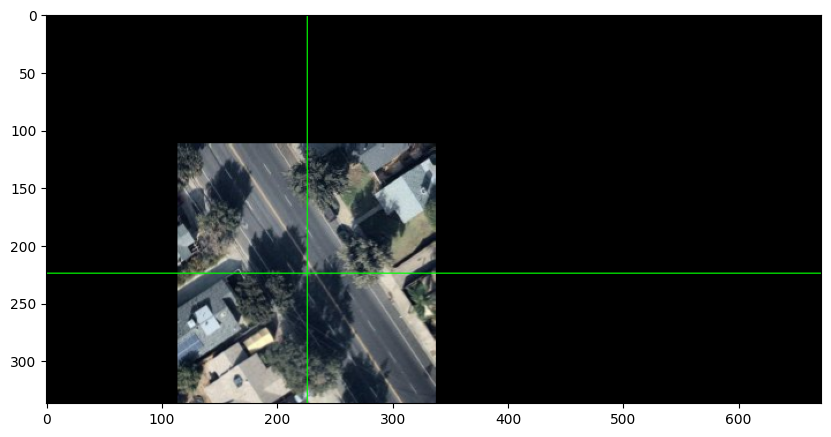

(112, 338)


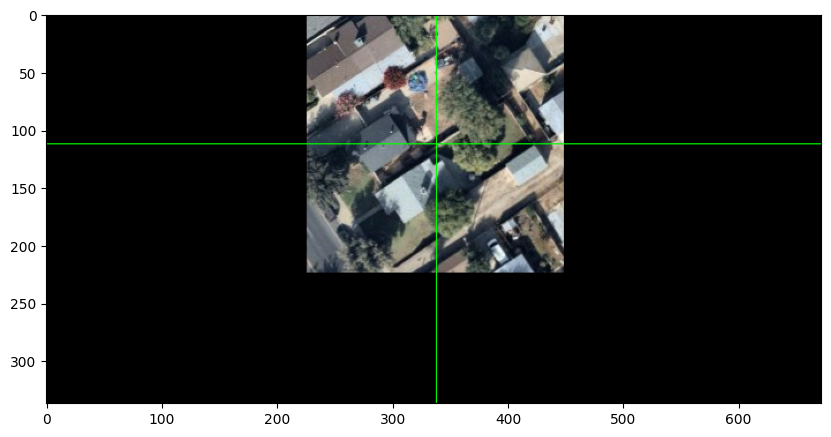

(112, 448)


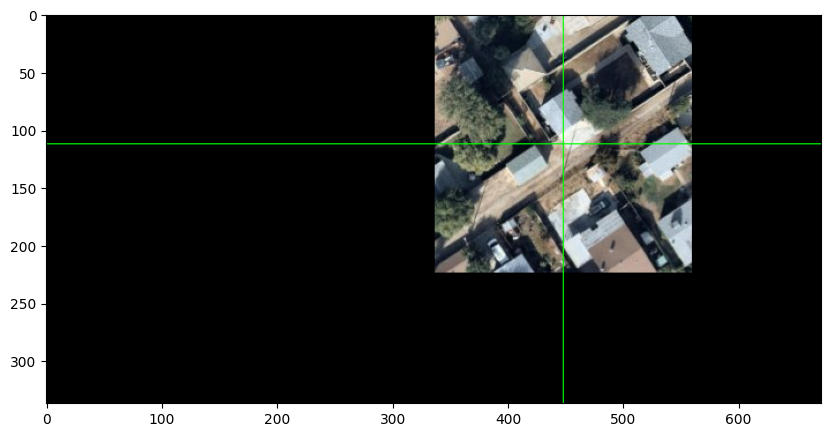

(224, 338)


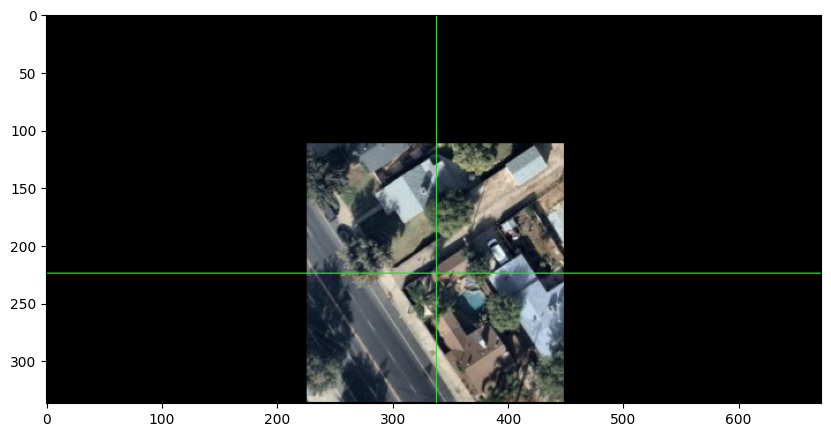

(224, 448)


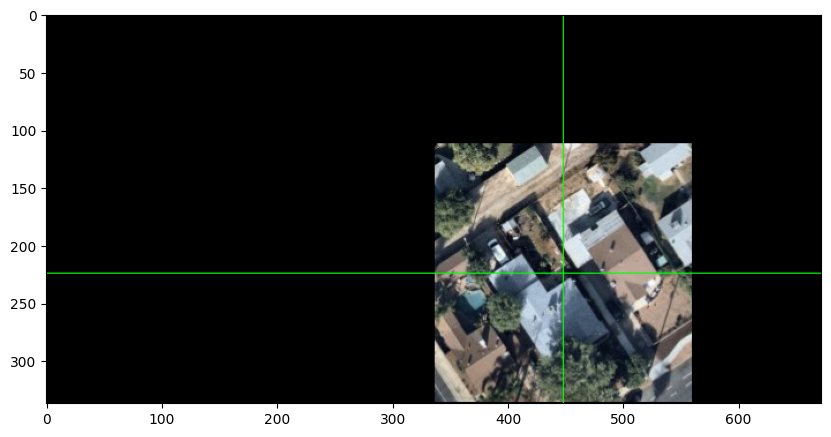

(112, 560)


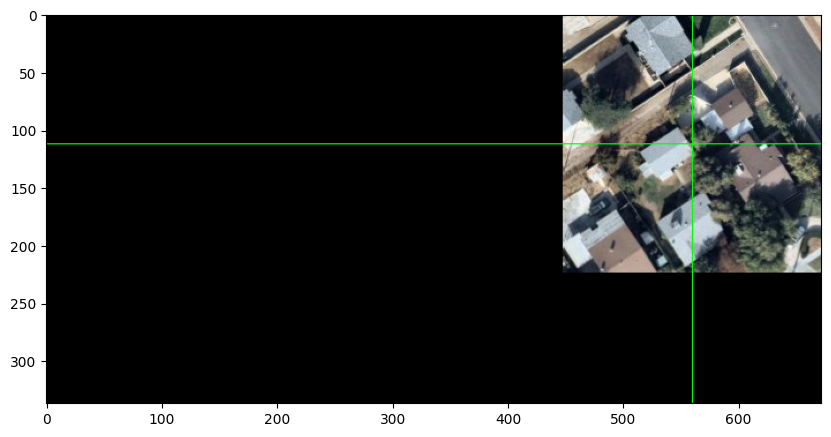

[(112, 226), (224, 112), (224, 226), (112, 338), (112, 448), (224, 338), (224, 448), (112, 560)]
8


In [23]:
from stitching.timelapser import Timelapser

def get_first_nonzero_pixel(ndarr):
    return np.argwhere(ndarr > 0)[0][:2]

def get_center(corner, size):
    return (round(corner[0] + size[1] / 2), round(corner[1] + size[0] / 2))

timelapser = Timelapser('as_is')
timelapser.initialize(final_corners, final_sizes)
dex = 1
centers = []
for img, corner, size in zip(warped_final_imgs, final_corners, final_sizes):
    timelapser.process_frame(img, corner)
    frame = timelapser.get_frame()
    centers.append(get_center(get_first_nonzero_pixel(frame), size))

print(centers)
print(len(centers))

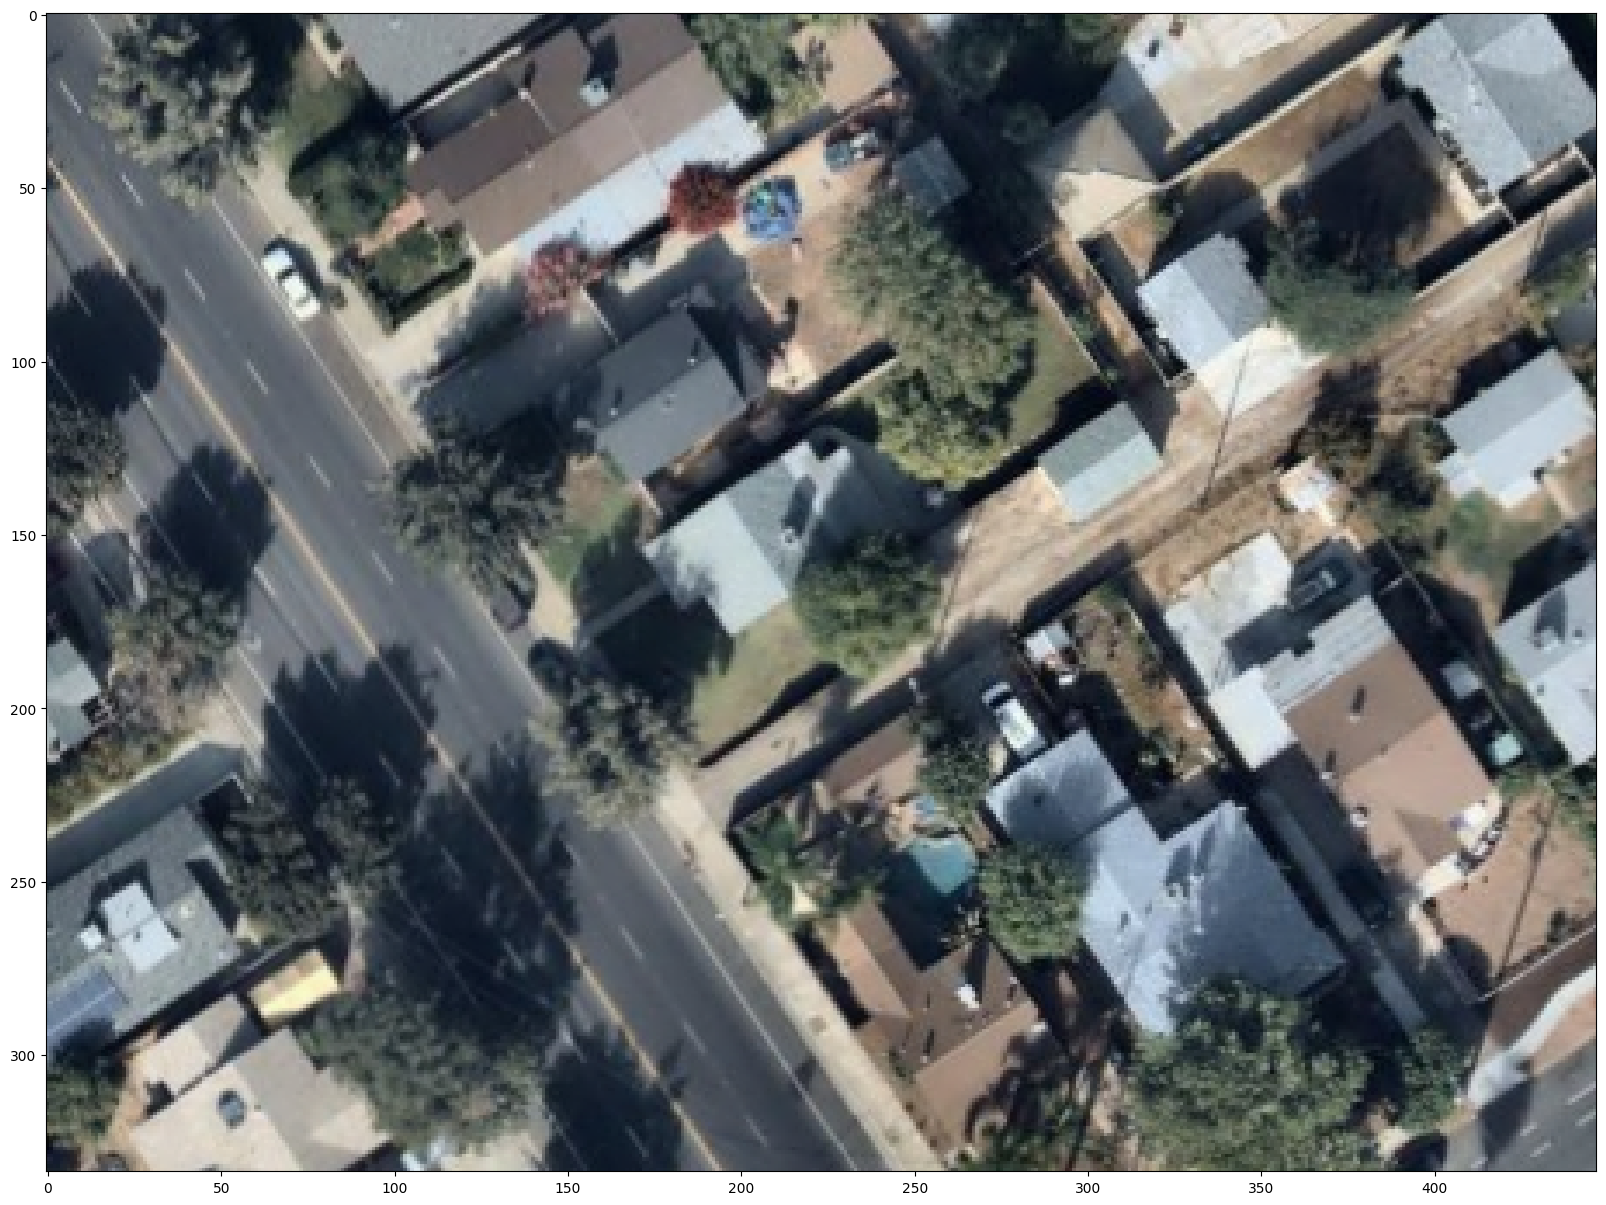

In [24]:
from stitching import Stitcher

stitcher = Stitcher()
panorama = stitcher.stitch(sequential_imgs)
plot_image(panorama, (20,20))